### Table of Contents

* [Wind Energy Analysis and Prediction](#Wind-Energy-Analysis-and-Prediction)
* [Gather and Clean the Data](#Gather-and-Clean-the-Data)
* [Exploritory Data Analysis](#Exploritory-Data-Analysis)
* [Model the Data](#Model-the-Data)
* [Conclusion and Recomendations](#Conclusion-and-Recomendations)

# Wind Energy Analysis and Prediction
---

### Problem Statement 

I am an analyst at General Analytics, a consulting company which expertise is in forecasting. Our audience is the forecasting department at (Electric Reliability Council of Texas) or ERCOT, the texas power regulator. We want to sell them an application that predicts hourly wind power output for the next month. In this project, we will attempt to create a model to predict the hourly wind power output for the ERCOT power grid for a month's time span. Our baseline will be the mean of the power output over a month timespan, and we will see if we can create a model that will outperform that baseline. Our evaluation metrics will be Mean Squared Error, Mean Absolute Error, and Root Mean squared Error.

### Background

A combination of seven power sources supply the Texas power grid, these include Gas, Hydro-Electric, Nuclear, Solar, Wind, Coal, and Other sources. The top three sources are Natural Gas, Wind, and Coal. Historically coal has been the main power generator for American power grids, however, due to climate change policies, American electric power generation is switching to carbon-free renewable energy sources. In America's path to zero carbon emissions, Natural gas, which has a less carbon footprint than coal, has become the reliable transition fuel for America's power generation. In the ERCOT power grid, the two main renewable resources are wind and solar. These two sources do not provide power as consistently as natural gas, solar power output is reduced when it is cloudy and zero at night, wind turbines won't generate power when the wind is not blowing. When these renewable power sources are reduced due to weather or sunlight, Natural Gas power plants increase their power output to meet the demand of the power grid. With a model that can predict wind power output a month into the future, ERCOT can better plan how much natural gas power to feed into the system.

### Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**Datime**|*datetime64*|df| Datetime index of dataframe (Hourly). | 
|**coal_mwh**|*int64*|df| ERCOT Hourly power generation from Coal Plants | 
|**hydro_mwh**|*int64*|df| ERCOT Hourly power generation from Hydo-Electric Plants | 
|**nuclear_mwh**|*int64*|df| ERCOT Hourly power generation from Nuclear Plants |
|**other_sources_mwh**|*int64*|df| ERCOT Hourly power generation from Other Sources |
|**solar_sources_mwh**|*int64*|df| ERCOT Hourly power generation from Solar Generation |
|**wind_sources_mwh**|*int64*|df| ERCOT Hourly power generation from Wind Plants |
|**demand_mwh**|*int64*|df| ERCOT Hourly power demand |

### Imports

In [305]:
import pandas as pd
import datetime as dt
import numpy as np
import missingno as msno
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf 
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import auto_arima

from prophet import Prophet as proph
from prophet.plot import plot_plotly
from prophet.diagnostics import performance_metrics, cross_validation

plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["lines.linewidth"] = 2 
plt.style.use("seaborn-muted") 

#supress output from prophet
import warnings
warnings.filterwarnings("ignore")

#Set random Seed
import random
random.seed(42)

### Functions

In [444]:
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    """
    This fuction is helpfull to interpret the output of 
    an ADF test, showing 5% P-value
    """
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

def make_season_dict():
    """
    The Purpose of this function is to take in the
    number of the month (1-12), and return what season
    the month is in (1:spring, 2:summer, 3:fall, 4:winter)
    """
    dict_ = {}
    for month in list(range(1,13)):
        if 3 <= month <= 5:
            dict_[month] = 1
        elif 6 <= month <= 8:
            dict_[month] = 2
        elif 9 <= month <= 11:
            dict_[month] = 3
        else:
            dict_[month] = 4
    return dict_

def make_workday_dict():
    """
    The Purpose of this function is to take in the
    day of the week and return if it is a workday or weekend
    (1:work_day, 0:weekend)
    """
    dict_ = {}
    for day in list(range(0,7)):
        if 0 <= day <= 4:
            dict_[day] = 1
        else:
            dict_[day] = 0
    return dict_

# this function takes in a complete dataframe and returns a DF with datetime range and resampled 
def format_dataframe(range_start = '2020-01-01', range_end = '2021-10-14', sample = 'H'):
    """
    This function takes in a complete dataframe
    and returns a DF with datetime range and resampled
    with user choice of sample type.
    """
    df_range = df[['wind_mwh']][range_start:range_end]
    df_resampled = df_range.resample(sample).mean()
    return df_resampled

def profit_format(dataframe):
    """
    This function coverts our dataframe and converts it
    to the format of that facebook prophet can use. changing
    datetime from an index to a column.
    """
    data = {
    'y': dataframe.wind_mwh.values,
    'ds': dataframe.index.values
    }
    pro_df = pd.DataFrame(data=data)
    return pro_df

def train_test_splitter(dataframe, train_percent=0.95):
    """
    This function splits our dataframe, into train sets 
    and test sets for our timeseries forcasts.
    """
    train_size = int(dataframe.shape[0] * train_percent)
    train = dataframe.loc[:train_size,:]
    test = dataframe.loc[train_size:,:]
    return train, test

def evaluate_model(y_true, y_pred):
    """
    This function evaluates our models on three metrics. models
    must be of the same size and indexing
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return {
        "MAE": round(mae,3),
        "MSE": round(mse,3),
        "RMSE": round(rmse,3),
           }

def prophet_model(train, test, interval_width= 0.95):
    """
    This model takes in train and test sets. it will then run
    facebooks prophet alogrythem to forcast time series data. the 
    data is then evaluated against the test with the Evaluate model
    function. It then produces charts of Test data vs. Forcasted data
    as well as train data with forcasted data with 95% confedence interval
    """

    # Instantiate the model with parameters
    model = proph(interval_width=0.95).fit(train)
    forecast = model.predict(test)

     # Plot the model and forecast
    plt.figure(figsize=(12,5))
    plt.plot(forecast.ds, forecast.yhat, color='red', label='Forcast')
    plt.plot(test.ds,test.y, label='test data')
    plt.title('Test Data With Forecast', fontsize=20)
    plt.xlabel("Date (Hourly)", fontsize=16)
    plt.legend();

    # plot forcast data with CI, and training data
    fig = model.plot(forecast, uncertainty=True, figsize=(12, 5))
    plt.ylim(bottom=0, top=30000)
    plt.title("Training Data with Forecast", fontsize=20)
    plt.xlabel("Date (Hourly)", fontsize=16);
    plt.xlim([dt.date(2021,7,1), dt.date(2021,10,14)])
    
    #evaluate the model
    y_true = test[['y']].reset_index(drop=True)
    y_pred = forecast[['yhat']].reset_index(drop=True)
    print("Model Evaluation:",evaluate_model(y_true, y_pred))
    y_true = test[['y']].reset_index(drop=True)
    y_pred = np.full_like(y_true, y_true.mean())
    print("Null Model Assume the Mean:",evaluate_model(y_true, y_pred))

## Gather and Clean the Data
---

In [445]:
# Read in Data, format the index to be datetime
coal = pd.read_csv('../Data/Net_generation_from_coal_for_Texas_(region)_hourly_-_UTC_time.csv', parse_dates=['datetime'], index_col='datetime')
hydro = pd.read_csv('../Data/Net_generation_from_hydro_for_Texas_(region)_hourly_-_UTC_time.csv', parse_dates=['datetime'], index_col='datetime')
gas = pd.read_csv('../Data/Net_generation_from_natural_gas_for_Texas_(region)_hourly_-_UTC_time.csv', parse_dates=['datetime'], index_col='datetime')
nuclear = pd.read_csv('../Data/Net_generation_from_nuclear_for_Texas_(region)_hourly_-_UTC_time.csv', parse_dates=['datetime'], index_col='datetime')
other = pd.read_csv('../Data/Net_generation_from_other_for_Texas_(region)_hourly_-_UTC_time.csv', parse_dates=['datetime'], index_col='datetime')
solar = pd.read_csv('../Data/Net_generation_from_solar_for_Texas_(region)_hourly_-_UTC_time.csv', parse_dates=['datetime'], index_col='datetime')
wind = pd.read_csv('../Data/Net_generation_from_wind_for_Texas_(region)_hourly_-_UTC_time.csv', parse_dates=['datetime'], index_col='datetime')
demand = pd.read_csv('../Data/Demand_for_Texas_(region)_hourly_-_UTC_time.csv', parse_dates=['datetime'], index_col='datetime', )

In [308]:
# Merge the dataframes from the different sources into one DataFrame
from functools import reduce

data_frames = [coal, hydro, gas, nuclear, other, solar, wind, demand]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['datetime'],
                                            how='inner'), data_frames)

In [309]:
#check datatypes
df_merged.dtypes

coal_mwh             int64
hydro_mwh            int64
natural_gas_mwh      int64
nuclear_mwh          int64
other_sources_mwh    int64
solar_mwh            int64
wind_mwh             int64
demand_mwh           int64
dtype: object

In [310]:
# Check for missing Values.
df_merged.isnull().sum()

coal_mwh             0
hydro_mwh            0
natural_gas_mwh      0
nuclear_mwh          0
other_sources_mwh    0
solar_mwh            0
wind_mwh             0
demand_mwh           0
dtype: int64

Thankfully this EIA Government data has no missing values.

In [311]:
df_merged.head()

,coal_mwh,hydro_mwh,natural_gas_mwh,nuclear_mwh,other_sources_mwh,solar_mwh,wind_mwh,demand_mwh
datetime,,,,,,,,
2021-10-14 05:00:00,8175,24,22878,2518,96,0,9610,43472
2021-10-14 04:00:00,8663,54,25436,2518,144,0,9442,46430
2021-10-14 03:00:00,8693,55,28195,2517,88,0,9840,49494
2021-10-14 02:00:00,9244,36,29726,2517,110,0,10579,52095
2021-10-14 01:00:00,9060,27,31002,2516,132,24,11222,53958


In [312]:
df_merged.to_csv('../Data/texas_power_gen.csv', index=True)

This Data was sourced from the Energy Information Administration (EIA). In this porject I found that most power utilitys will freely publish their data, it is helpfull for local businesses and governement angencies to keep a watch of the very energy that keeps them running. However, when I went to pull the data from the [EIA website](https://www.eia.gov/electricity/gridmonitor/expanded-view/custom/pending/GenerationByEnergySource-14/edit), I found that if you want the data from every source of power, you can can only get the last 30 days worth at a time. I did find that you can download almost 3 years worth of data if you pull each csv individually. So that is why we started with eight csvs, but here we will reduce these to just one csv for ease of future work. So now we have about 4 years worth of power data to do our modeling, this data is sourced hourly, so we will have to deal with the granularity.

In [357]:
#read in the dataframe
df = pd.read_csv('../Data/texas_power_gen.csv', parse_dates=['datetime'], index_col='datetime')
df.head()

,coal_mwh,hydro_mwh,natural_gas_mwh,nuclear_mwh,other_sources_mwh,solar_mwh,wind_mwh,demand_mwh
datetime,,,,,,,,
2021-10-14 05:00:00,8175,24,22878,2518,96,0,9610,43472
2021-10-14 04:00:00,8663,54,25436,2518,144,0,9442,46430
2021-10-14 03:00:00,8693,55,28195,2517,88,0,9840,49494
2021-10-14 02:00:00,9244,36,29726,2517,110,0,10579,52095
2021-10-14 01:00:00,9060,27,31002,2516,132,24,11222,53958


In [358]:
df.shape

(28753, 8)

In [359]:
df.describe()

,coal_mwh,hydro_mwh,natural_gas_mwh,nuclear_mwh,other_sources_mwh,solar_mwh,wind_mwh,demand_mwh
count,28753.000000,28753.000000,28753.000000,28753.000000,28753.000000,28753.000000,28753.000000,28753.000000
mean,8983.748931,81.252913,20159.538448,4720.182729,104.303934,905.045804,9240.701944,44318.056029
std,2710.534867,72.056068,8829.264738,562.619566,1100.644531,1440.756875,5072.521144,9800.311280
min,2136.000000,0.000000,411.000000,2466.000000,0.000000,0.000000,168.000000,27449.000000
25%,6751.000000,25.000000,13754.000000,4089.000000,14.000000,0.000000,4962.000000,37308.000000
50%,8937.000000,68.000000,19017.000000,5006.000000,20.000000,36.000000,8758.000000,41717.000000
75%,11082.000000,116.000000,25252.000000,5099.000000,34.000000,1285.000000,13324.000000,49528.000000
max,15319.000000,386.000000,48797.000000,5149.000000,27137.000000,6955.000000,23368.000000,74533.000000


Above we can see the mean of all the power sources match up appoximatly with the total demand power or the grid. You can also see how the Standard deviations of these power sources almost match the mean. This is due to the cyclic nature of power generation and demand, at night the power demand goes down due to people resting and business closing. The "other sources" of power is quite intresting on the EIA website I saw some large spikes they are not a major contributor to the power grid. After some research I believe that this might be Geothermal, and Biomass.

I also noticed that the data is writting in UTC not in local time which is CST, for interpretablity ill push back to CST which is -6 hours from UTC. This can be done easly in the code below.

In [360]:
# Adjusting time to match Central Standard time
# Localizing the timezone to UTC
df.index = df.index.tz_localize('UTC')

# convert to Central Standard Time
df.index = df.index.tz_convert('US/Central')
df.index

DatetimeIndex(['2021-10-14 00:00:00-05:00', '2021-10-13 23:00:00-05:00',
               '2021-10-13 22:00:00-05:00', '2021-10-13 21:00:00-05:00',
               '2021-10-13 20:00:00-05:00', '2021-10-13 19:00:00-05:00',
               '2021-10-13 18:00:00-05:00', '2021-10-13 17:00:00-05:00',
               '2021-10-13 16:00:00-05:00', '2021-10-13 15:00:00-05:00',
               ...
               '2018-07-02 10:00:00-05:00', '2018-07-02 09:00:00-05:00',
               '2018-07-02 08:00:00-05:00', '2018-07-02 07:00:00-05:00',
               '2018-07-02 06:00:00-05:00', '2018-07-02 05:00:00-05:00',
               '2018-07-02 04:00:00-05:00', '2018-07-02 03:00:00-05:00',
               '2018-07-02 02:00:00-05:00', '2018-07-02 01:00:00-05:00'],
              dtype='datetime64[ns, US/Central]', name='datetime', length=28753, freq=None)

## Exploritory Data Analysis
---

In [361]:
# Create a total feed in value
# This will allow us to measue how well the system
# is supplying the grid.
df['total_feed_in'] = df[df.columns[:-1]].sum(axis=1) 
df.head()

,coal_mwh,hydro_mwh,natural_gas_mwh,nuclear_mwh,other_sources_mwh,solar_mwh,wind_mwh,demand_mwh,total_feed_in
datetime,,,,,,,,,
2021-10-14 00:00:00-05:00,8175,24,22878,2518,96,0,9610,43472,43301
2021-10-13 23:00:00-05:00,8663,54,25436,2518,144,0,9442,46430,46257
2021-10-13 22:00:00-05:00,8693,55,28195,2517,88,0,9840,49494,49388
2021-10-13 21:00:00-05:00,9244,36,29726,2517,110,0,10579,52095,52212
2021-10-13 20:00:00-05:00,9060,27,31002,2516,132,24,11222,53958,53983


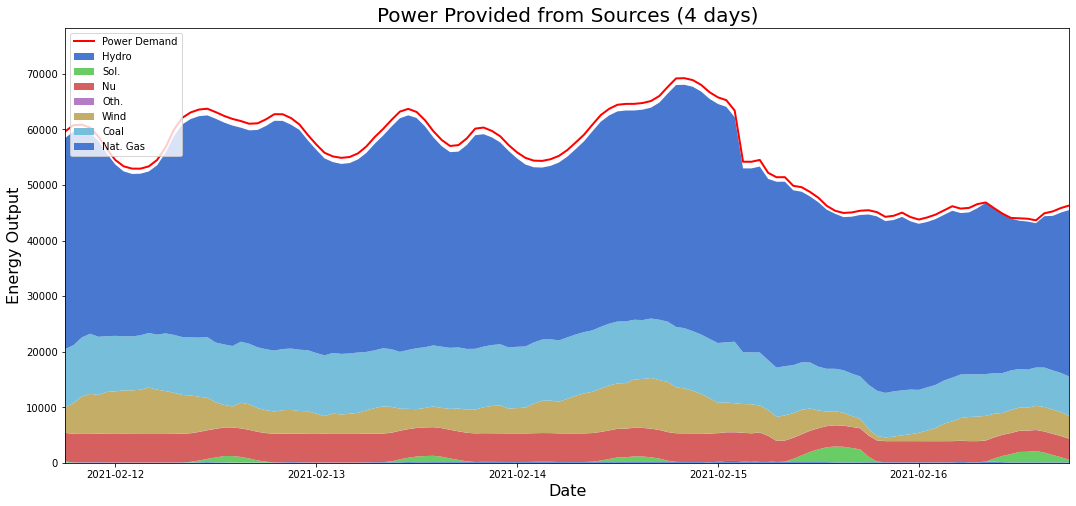

In [433]:
# Plot Stacked Area Chart of Power Output with Demand
c=df.coal_mwh
n=df.natural_gas_mwh
h=df.hydro_mwh
nu=df.nuclear_mwh
o=df.other_sources_mwh
s=df.solar_mwh
w=df.wind_mwh

plt.plot(figsize=(20,8))
plt.stackplot(df.index, h, s, nu, o ,w ,c ,n , labels=['Hydro', 'Sol.', 'Nu', 'Oth.', 'Wind', 'Coal', 'Nat. Gas'])
plt.plot(df['demand_mwh'], color='red', label="Power Demand")
plt.xlim([dt.date(2021,2,12), dt.date(2021,2,17)])
plt.legend(loc='upper left')
plt.xlabel("Date", fontsize=16)
plt.ylabel("Energy Output",fontsize=16)
plt.title("Power Provided from Sources (4 days)", fontsize=20);

Here we can see the sum of power generated from the different powersoruces notice how solar in blue goes to zero at night due to the lack of sun. This Data is sourced from [ERCOT](https://en.wikipedia.org/wiki/Electric_Reliability_Council_of_Texas), the powergrid operatior of Texas, Here natural gas is the largest generator of Electrictiy, followed unsuprisingly by wind. Texas produces the most power from wind than any other american state from this [wikipedia aticle](https://en.wikipedia.org/wiki/Wind_power_in_Texas#Renewable_Portfolio_Standard) if texas was its own coutry it would rank 5th in the world for wind engergy. 

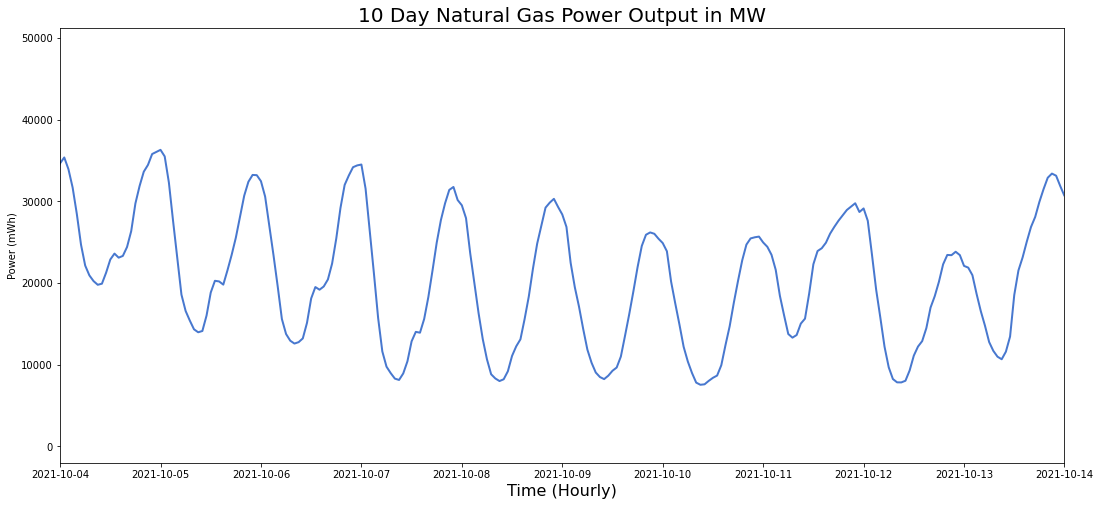

In [363]:
plt.plot(df.natural_gas_mwh,label='Nat.Gas')
plt.title("10 Day Natural Gas Power Output in MW", fontsize=20)
plt.xlim([dt.date(2021,10,4), dt.date(2021,10,14)])
plt.xlabel("Time (Hourly)", fontsize=16)
plt.ylabel("Power (mWh)");

Here we can see the cyclic nature of natural gas power generation over this 10 day period. I was curious to know why would natural gas power generation be cyclical if it is a constant source. I think its because solar and wind peak during the daylight hours and there is a need for another reliable sorce of power after hours. lets see below what it looks like when we overlay solar and wind with natural gas.

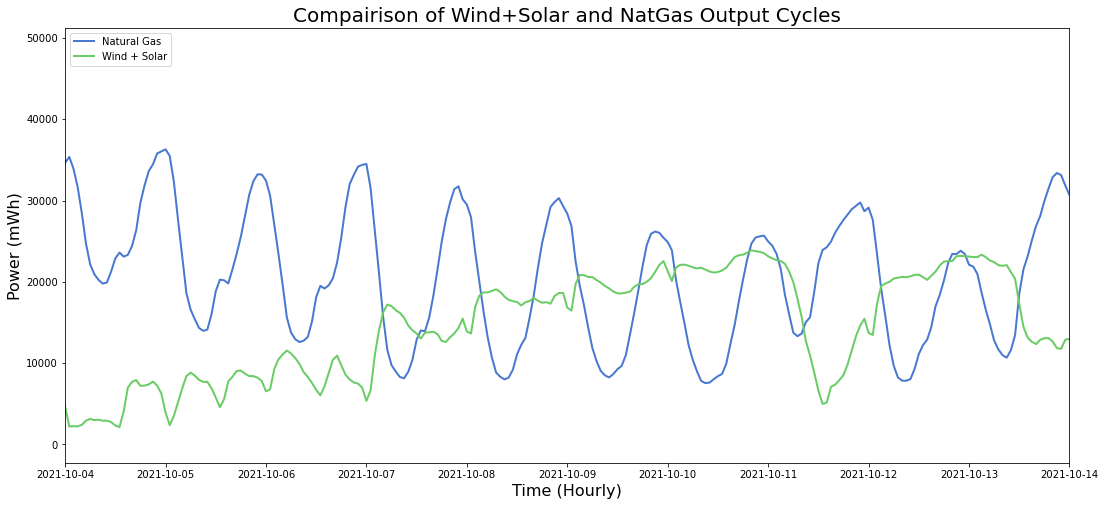

In [364]:
plt.plot(df.natural_gas_mwh, label='Natural Gas')
plt.plot(df.wind_mwh + df.solar_mwh, label='Wind + Solar')
plt.legend(loc='upper left')
plt.title("Compairison of Wind+Solar and NatGas Output Cycles", fontsize=20)
plt.xlim([dt.date(2021,10,4), dt.date(2021,10,14)])
plt.xlabel("Time (Hourly)", fontsize=16)
plt.ylabel("Power (mWh)", fontsize=16);

We dont quite see that opposite cycle when we combine wind and solar and plot it with Natural gas but there are point where there is low wind and solar outputs and the natural gas power output is high.

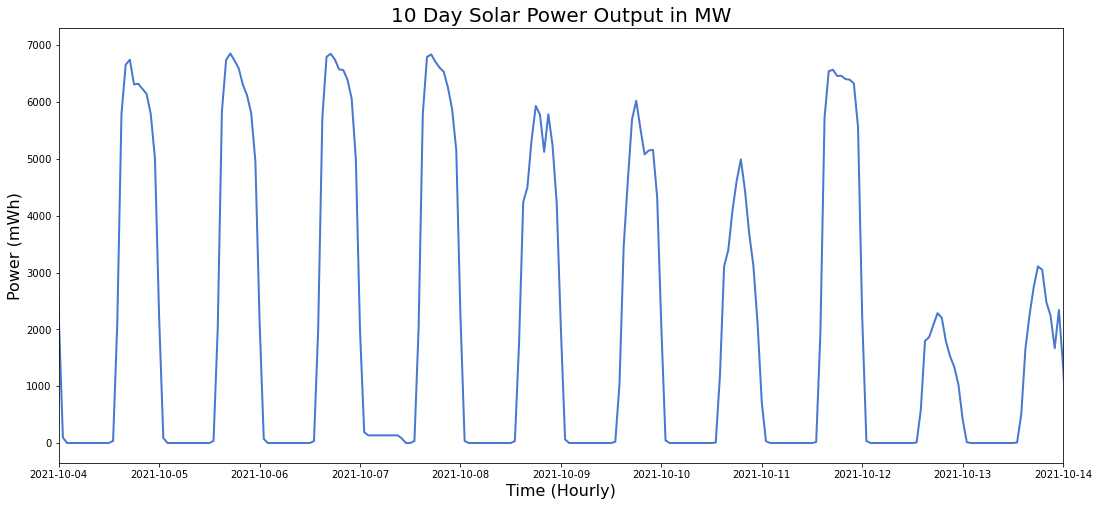

In [365]:
plt.plot(df.solar_mwh, label='Solar')
plt.title("10 Day Solar Power Output in MW", fontsize=20)
plt.xlim([dt.date(2021,10,4), dt.date(2021,10,14)])
plt.xlabel("Time (Hourly)", fontsize=16)
plt.ylabel("Power (mWh)", fontsize=16);

Here we can see solar output for a 10 day period from Oct-10 to Oct-14. We can see how the solar power drops to zero at night due to the lack of sunlight, other factors might include overcast skys.

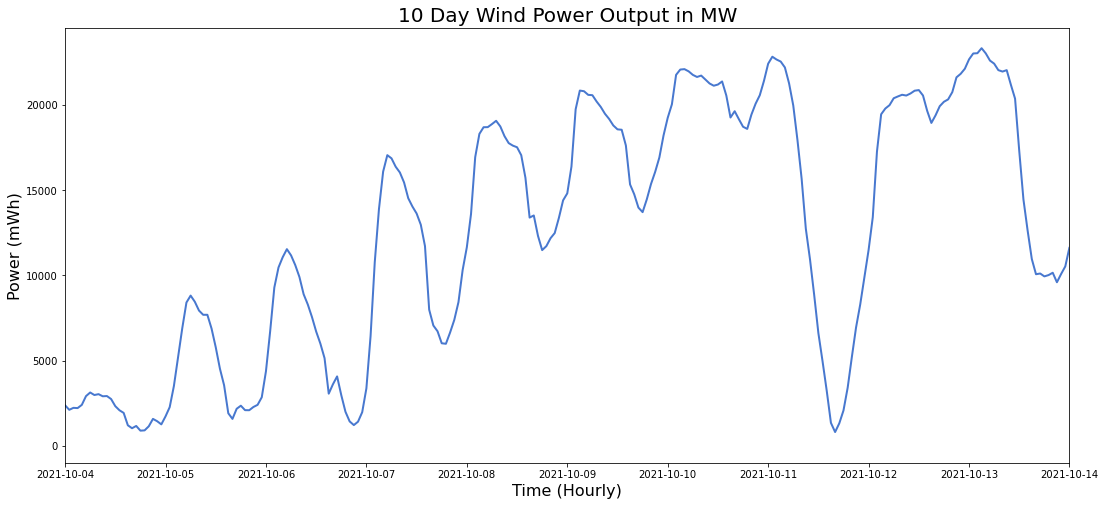

In [366]:
plt.plot(df.wind_mwh)
plt.title("10 Day Wind Power Output in MW", fontsize=20)
plt.xlim([dt.date(2021,10,4), dt.date(2021,10,14)])
plt.xlabel("Time (Hourly)", fontsize=16)
plt.ylabel("Power (mWh)", fontsize=16);

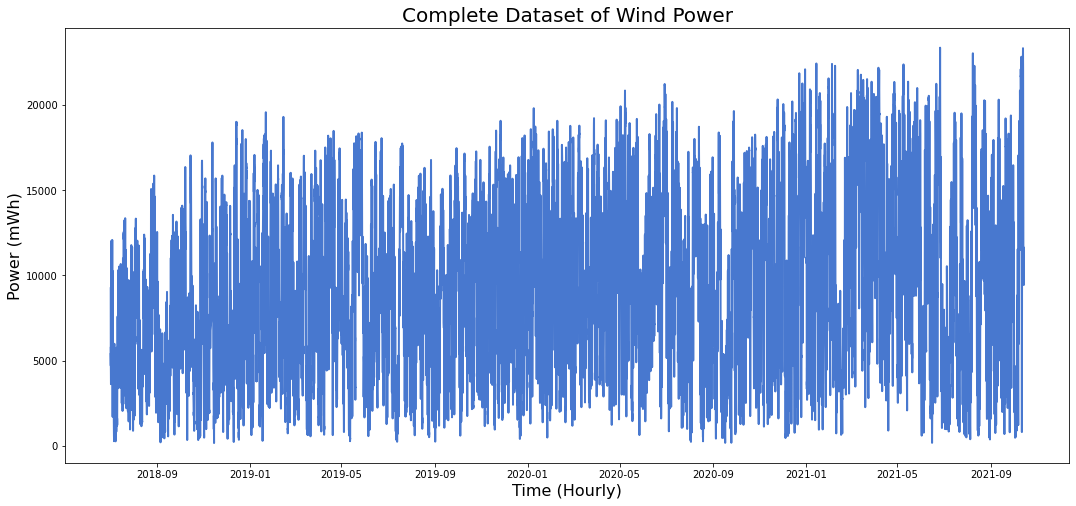

In [367]:
plt.plot(df.wind_mwh)
plt.title("Complete Dataset of Wind Power", fontsize=20)
plt.xlabel("Time (Hourly)", fontsize=16)
plt.ylabel("Power (mWh)", fontsize=16);

## Model the Data
---

### Resample to Hourly Wind Measurements for 1.5 Months

Since our dataset has a lot of information, hourly data from the last 3 years. I decided to start small with data from the last 1.5 months and build from there, the reasoning is im not sure how much information from 2 years ago help in predicting hourly wind power for the next few days. Time willing will encorporate more data and see how that changes the models performance.

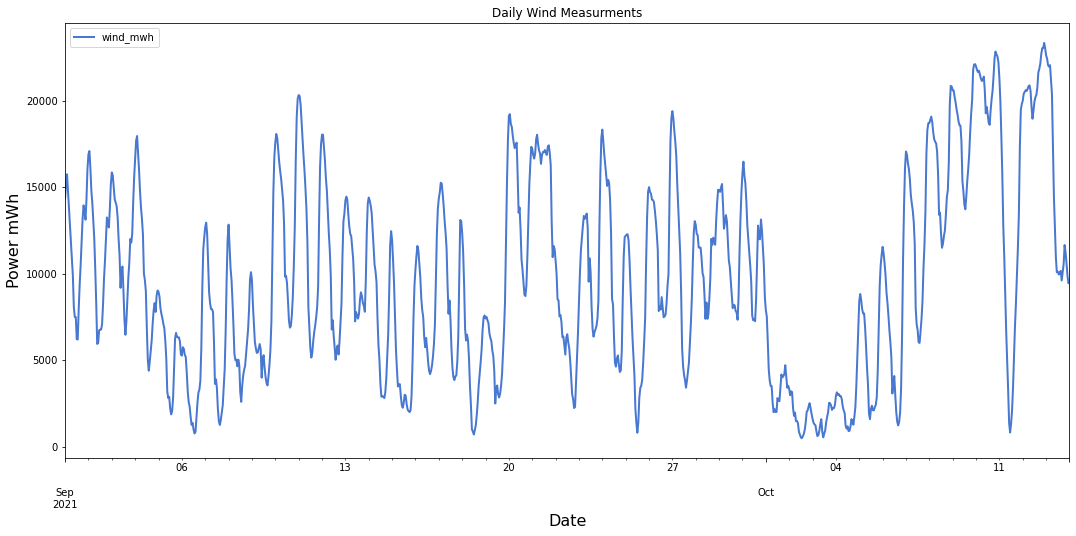

In [368]:
#Resample data to get a mean of daily generation.
wind_df = df[['wind_mwh']].resample('H').mean()

#lets start with model for 1.5 months
wind_df = wind_df['2021-9-1':]

# Plot Resampled Daily wind measurments
wind_df.plot()
plt.title("Daily Wind Measurments")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Power mWh",fontsize=16)
plt.xlim([dt.date(2021,9,1), dt.date(2021,10,14)]);

In [369]:
# Checking for nulls in the resampled set
wind_df.isnull().sum()

# fill NaN using simple imputer KNN
imputer = KNNImputer(n_neighbors=2)
wind_df['wind_mwh'] = imputer.fit_transform(wind_df[['wind_mwh']])

### Feature Engineering

Here we will create more date-time related features to aid in our predictions.

In [370]:
# Incorporate season into dataframe
wind_df['season']= wind_df.index.month.map(make_season_dict())

#incorporate workday and weekend
wind_df['work_day'] = wind_df.index.weekday.map(make_workday_dict())

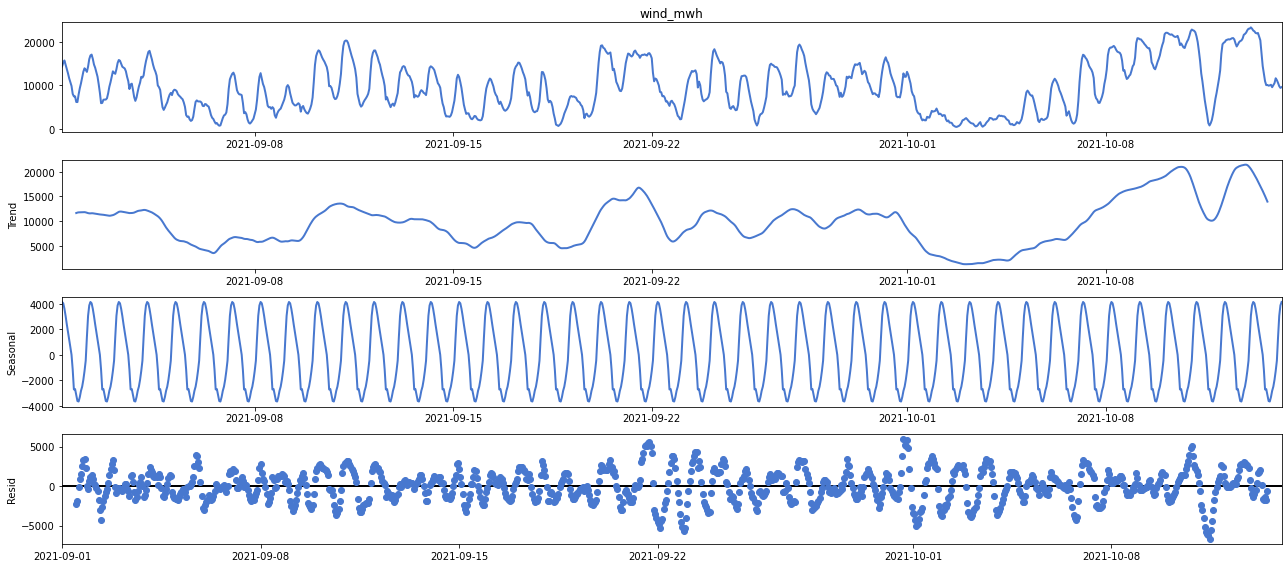

In [371]:
# Time Series Decomposition, Allows us to decompose our time-series into 3
# distinct components Trend, Seasonality and Noise.
plt.rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(wind_df.wind_mwh, model='additive')
fig = decomposition.plot()
plt.show()

We can see from the Time-Series Decomposition above that to no suprize their is seasonality in our data, due to the fact that wind generation is cyclical throughout the day. In the trend plot we can see that there is no obvious trend in the data, but suspect that there is a trend as seasons change winds change. The plot of the residuals shows again that there is strong seasonality in our data and it is daily.

### ADFuller Testing

We will use a Agumented Dickey-fuller test to test if our daily wind data is stationary.

In [372]:
# Use funtion to interpret ADF test
interpret_dftest(adfuller(wind_df['wind_mwh']))

Test Statistic   -3.204251
p-value           0.019740
dtype: float64

Our data is not stationary. Lets now difference our data to get stationarity.

In [373]:
wind_df['wind_mwh_1_diff'] = wind_df['wind_mwh'].diff(1)
wind_df.dropna(inplace=True)

In [374]:
interpret_dftest(adfuller(wind_df['wind_mwh_1_diff']))

Test Statistic   -6.138835e+00
p-value           8.063256e-08
dtype: float64

We can now say that our data is stationary. Let move onto modeling.

### Train / Test Split

In [375]:
print(f'Number of observations for train: {len(wind_df.wind_mwh)*8//10}')

Number of observations for train: 825


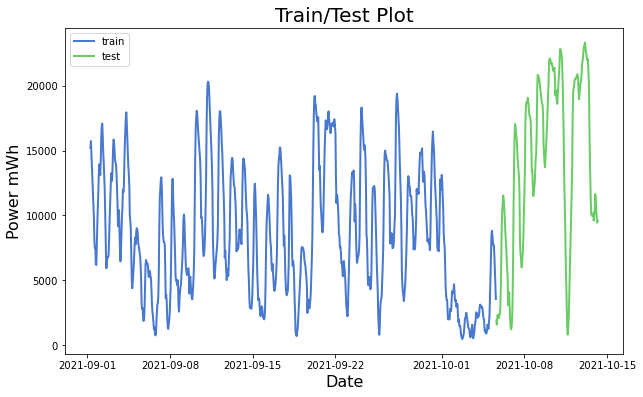

In [376]:
# Split the data into training and Testing sets 80% Train 20% Test
train = wind_df[['wind_mwh']].iloc[:825,:]
test = wind_df[['wind_mwh']].iloc[825:,:]

#plot train and test data
plt.figure(figsize=(10,6))
plt.plot(train,label='train')
plt.plot(test, label='test')
plt.title("Train/Test Plot", fontsize=20)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Power mWh", fontsize=16)
plt.legend();

Above you can see we split our data into

### Null Model (Baseline)

Before we start we will start with a baseline model to compair our future models to. In this project we will compaire our models to a model that just predicts the mean of the Test data.

In [377]:
baseline_mse = mean_squared_error(test.values, np.full_like(test, test.mean()))
baseline_rmse = mean_squared_error(test.values, np.full_like(test, test.mean()), squared=False)
print("Null Model MSE", baseline_mse)
print("Null Model RMSE", baseline_rmse)

Null Model MSE 43831111.25267801
Null Model RMSE 6620.506872791389


## ARIMA Modeling
---

We will use the most commonly used Methods for time-series forcasting, know as ARIMA which stands for Autoregressive Intergrated Moving Average. ARIMA Modeling has 3 different parameters (p,d,q), These three parameters account for seasonality, trend and noise.

Well start with finding the Autoregressive (p) value

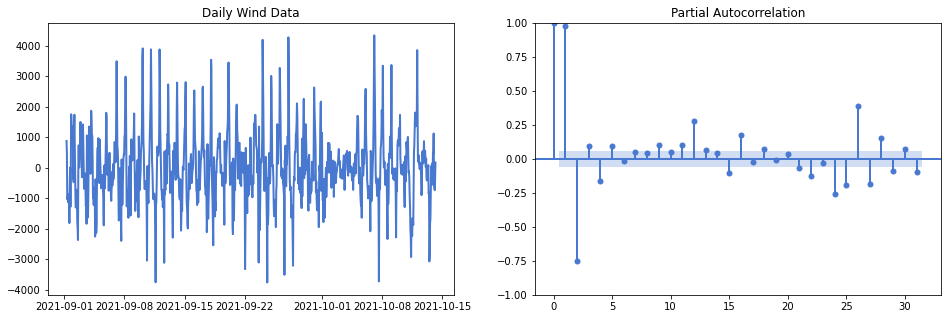

In [378]:
# Create a subplot for daily wind data and Partial ACF
fig, ax = plt.subplots(1,2, figsize= (16,5))
a = ax[0].plot(wind_df.wind_mwh_1_diff)
a = ax[0].set_title("Daily Wind Data")
b = plot_pacf(wind_df.wind_mwh, ax=ax[1])

From The Partial Auto Correlation above we will chose the lag "28" value since it seems to correlate with the original valiue the most away from the data closest to the orginal value.

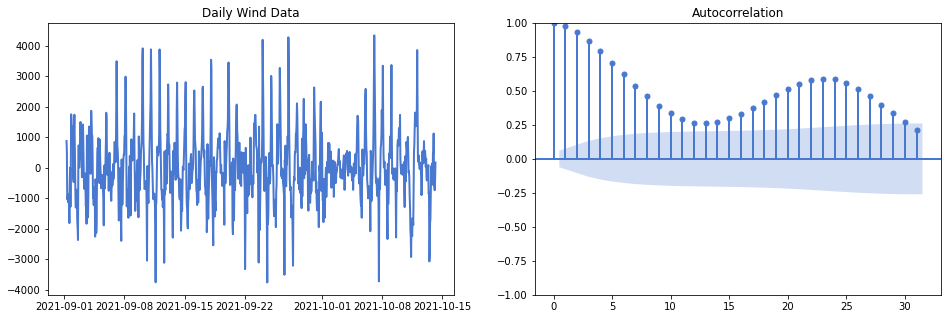

In [379]:
# Plot Autocorrelation 
fig, ax = plt.subplots(1,2, figsize= (16,5))
a = ax[0].plot(wind_df.wind_mwh_1_diff)
a = ax[0].set_title("Daily Wind Data")
b = plot_acf(wind_df.wind_mwh, ax=ax[1])

From the Autocorrelation well choose 23 again for for our (q) value since most of our values correlate with the original value I wan to pick something that correlates fro the next season.

### Model #1 ARIMA Model: AR(28), d=1, MA(23)

> For our first go we will use the stats model ARIMA model with the AR(p), MA(q) that we found on the ACF and PACF plots as well as d=1, since our data is differenced once.

In [394]:
# Build Model
model = ARIMA(train.wind_mwh, order=(28, 1, 23))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:               wind_mwh   No. Observations:                  825
Model:               ARIMA(28, 1, 23)   Log Likelihood               -6477.354
Date:                Sat, 23 Oct 2021   AIC                          13058.708
Time:                        21:58:02   BIC                          13303.845
Sample:                    09-01-2021   HQIC                         13152.747
                         - 10-05-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0766      2.535     -0.030      0.976      -5.046       4.892
ar.L2         -0.1058      1.805     -0.059      0.953      -3.643       3.431
ar.L3         -0.0532      1.474     -0.036      0.9

> We can see here that our p-vales are low meaning insignifigance. Our AIC is quite high 13226. AIC is the difference between the true likelyhood and the fitted liklyhood, a AIC of 13226, means our model does not fit the data very well. 

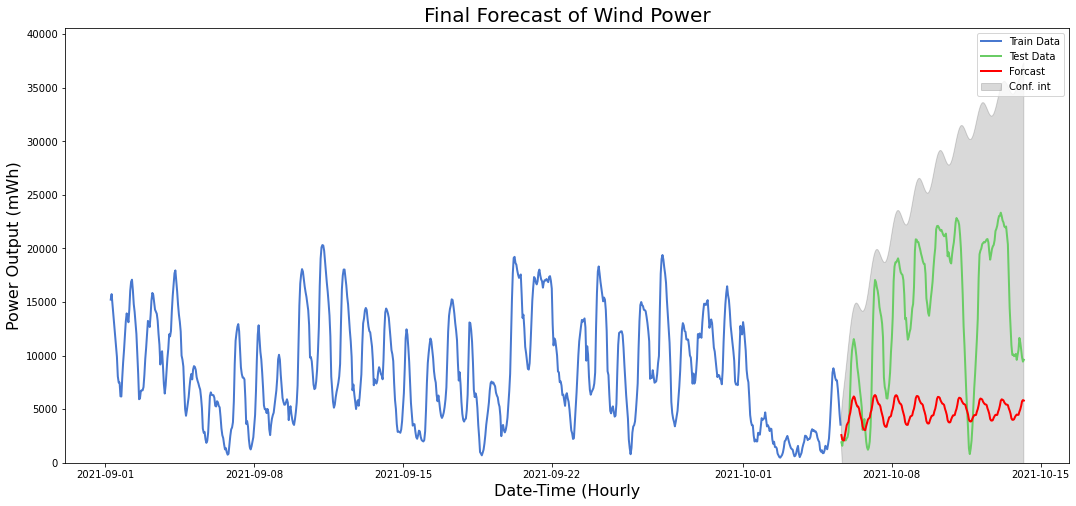

In [395]:
# Forecast
n_periods = test.shape[0]
# Forecast
fc = fitted.forecast(n_periods, alpha=0.05)  # 95% conf
index_of_fc = test.index

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train.wind_mwh, label='Train Data')
plt.plot(test.wind_mwh, label='Test Data')
plt.plot(fc_series, color='red', label='Forcast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15, label='Conf. int')

plt.title("Final Forecast of Wind Power", fontsize=20)
plt.xlabel("Date-Time (Hourly", fontsize=16)
plt.ylabel("Power Output (mWh)", fontsize=16)
plt.ylim(bottom=0)
plt.legend()
plt.show()

Above is the plot of the real wind power data plotted with the forecasting predictions in red. It is clear that our model is having a difficult time predicting the test data it seems to follow for about a day then goes back to predicting the mean. This is ok for predicting the hourly power generation for about 12-24 hours but not much after that. Lets Evaluate the model and see how well we did against a basline. Again it is good to see the 95% confedence interval where instead of predicting a specficic value one can just state that we are 95% confedent that our forcast will be in this range.

MSE: 125815327.03
RMSE: 11216.74
Baseline: 6620.51


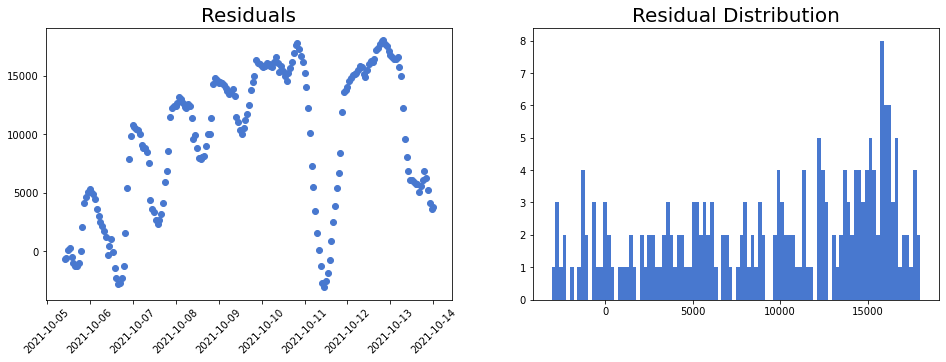

In [393]:
# Evaluate the model
error = mean_squared_error(test.values, fc)
baseline = mean_squared_error(test.values, np.full_like(test, test.mean()))
print(f'MSE: {round(error, 2)}')
print(f'RMSE: {round(error**.5, 2)}')
print(f'Baseline: {round(baseline**.5, 2)}')

# Plot Residuals
fig, ax = plt.subplots(1,2, figsize=(16,5))

residuals =test.wind_mwh.values-fc
ax[0].scatter(test.index, (test.wind_mwh.values-fc))
ax[0].set_title("Residuals", fontsize=20)
ax[0].tick_params(axis='x', labelrotation = 45)

ax[1].hist(residuals, bins=100)
ax[1].set_title("Residual Distribution", fontsize=20);

We can see again that this model with an RMSE 12911, did not perform better than our baseline "predicting the mean. Our residuals are showing a trend of the data the model did not capture. Lets try a grid search using the Auto-Arima Model, this is commonly used in forcasting with ARIMA models since it can be trickey to decide what should be your AR(p) and MA(q). Auto-Arima Also takes into account Seasonality trends creating a SARIMA(p,d,q)x(P,D,Q) model, where, P, D and Q, are seasonal differencing. 

### Model #2 Auto-ARIMA Model

In [396]:
# Add params and Fit auto-Arima Model.
auto_arima_ = auto_arima(train.wind_mwh, 
                         d=1,           # data needs to be differenced once
                         max_p=5, 
                         max_q=5,
                         m=28,
                         seasonal=True, #This is true the data is seasonal on a 24 hour basis
                         random_state=42, 
                         error_action='ignore')

In [340]:
#summerize auto-Arima hyper-parameter results.
auto_arima_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  825
Model:               SARIMAX(3, 1, 5)   Log Likelihood               -6614.841
Date:                Sat, 23 Oct 2021   AIC                          13247.683
Time:                        20:53:48   BIC                          13290.111
Sample:                             0   HQIC                         13263.959
                                - 825                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9351      0.009    102.180      0.000       0.917       0.953
ar.L2          0.9173      0.017     52.942      0.000       0.883       0.951
ar.L3         -0.9876      0.009   -107.544      0.000      -1.006      -0.970
ma.L1         -0.3237      0.028    -11.424      0.000      -0.379      -0.268
ma.L2         -1.3998      0.033    -42.130      0.000      -1.465      -1.335
ma.L3          0.3458      0.046      7.580      0.000       0.256       0.435
ma.L4          0.5229      0.030     17.514      0.000       0.464       0.581
ma.L5          0.0613      0.031      1.980      0.048       0.001       0.122
sigma2      5.521e+05    2.6e-08   2.12e+13      0.000    5.52e+05    5.52e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.16   Jarque-Bera (JB):               295.29
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.29
Prob(H) (two-sided):                  0.24   Kurtosis:                         5.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.7e+28. Standard errors may be unstable.
"""

It looks like our AIC is slighly lower than our previous ARIMA model, and our P-values are low they should be below 0.05 to say that the Coef is signifigant. The auto ARIMA through an 

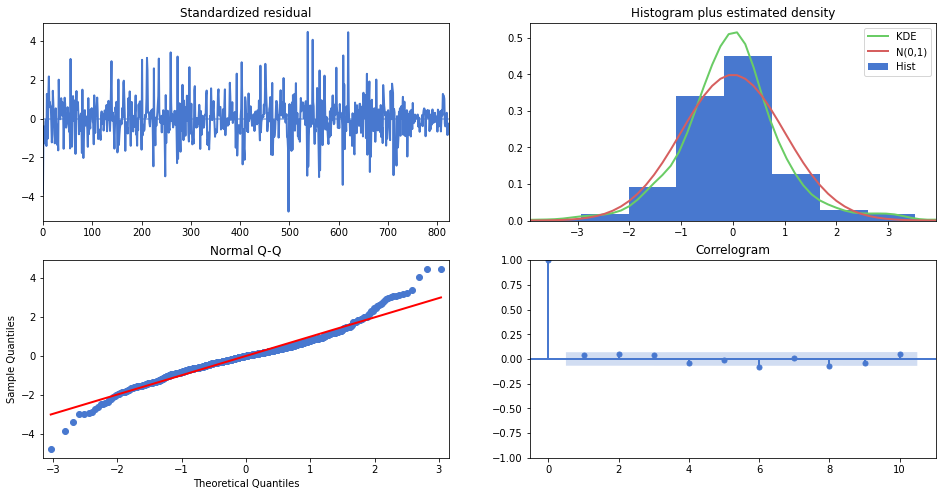

In [397]:
# Plot Auto-Arima Diagnostics
auto_arima_.plot_diagnostics(figsize=(16,8))
plt.show()

Residual Errors fluctuate arround a mean of zero which shows a good fit. The density plot shows a mean around zero which again is a good fit, this is a good fit to our taining data, lets see how well it fits our test data, on the figure below.

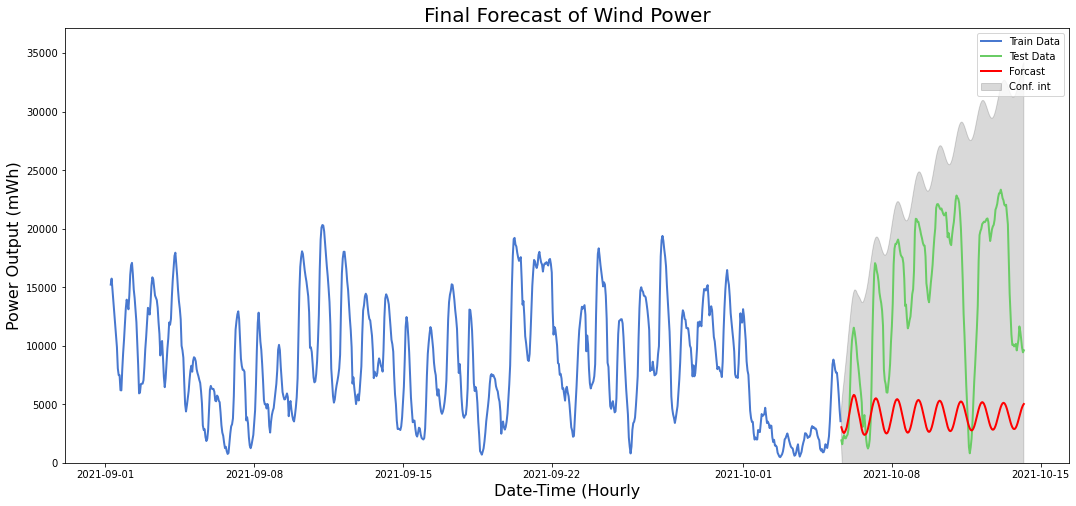

In [398]:
# Forecast
n_periods = test.shape[0]
fc_1, confint = auto_arima_.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = test.index

# make series for plotting purpose
fc_series = pd.Series(fc_1, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train.wind_mwh, label='Train Data')
plt.plot(test.wind_mwh, label='Test Data')
plt.plot(fc_series, color='red', label='Forcast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15, label='Conf. int')

plt.title("Final Forecast of Wind Power", fontsize=20)
plt.xlabel("Date-Time (Hourly", fontsize=16)
plt.ylabel("Power Output (mWh)", fontsize=16)
plt.ylim(bottom=0)
plt.legend()
plt.show()

We can see here that our predictions are not accurate past a single day, this is due to the random nature of wind power generation, this power is tied to the weather which is not very correlated with time. The cyclic nature that we are seeing is night and day where there is a change in wind patterns however, wind is influenced by several other factors including storms, and high and low pressure fronts moving over the wind turbines. 

MSE: 143460440.57
RMSE: 11977.5
Baseline: 6620.51


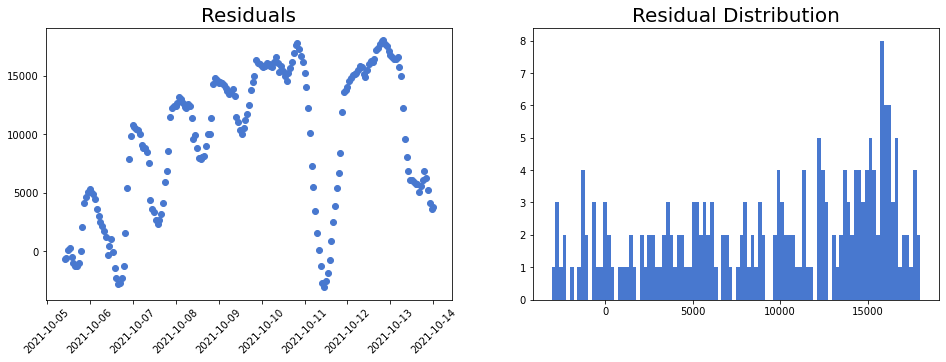

In [399]:
# Evaluate the model
error = mean_squared_error(test.values, fc_1)
baseline = mean_squared_error(test.values, np.full_like(test, test.mean()))
print(f'MSE: {round(error, 2)}')
print(f'RMSE: {round(error**.5, 2)}')
print(f'Baseline: {round(baseline**.5, 2)}')

# Plot Residuals
fig, ax = plt.subplots(1,2, figsize=(16,5))

residuals =test.wind_mwh.values-fc
ax[0].scatter(test.index, (test.wind_mwh.values-fc))
ax[0].set_title("Residuals", fontsize=20)
ax[0].tick_params(axis='x', labelrotation = 45)

ax[1].hist(residuals, bins=100)
ax[1].set_title("Residual Distribution", fontsize=20);

Looks like our SARIMA did worse than our manual entries. After many iterations I belive I have come to an understanding, I am trying to model hourly data for the next 10 days based off the previous month. I belive the short comming is that its not easy to find a trend in how hard the wind blows, hourly. Next we will try facebook forcasting model profit. It automates a lot of the preprocessing behind the scenes, and uses a different algorthem for forecasting.

### Model #3 Facebook Profit

Facebook prophet is an additive regression model that includes a number of highly advanced, intellegent forecasting methods. These methods include, a peacewise linear or logistic growth trend, prohet automatically detects changes in growth trends by selecting points where growth rates change, a Yearly seasonal component modeled with a forier series, a weekely seasonal component modeled using dummy variables, as well as a user-provided list of important holidays. In basic terms just likea linear regression model with beta coefficients: however in this case the beta coefficients, are not scalers they are functions in of themselves.

Lets start out using facebook prohets time series forcaster, We have to first convert our dataframes into a format that FB prophet can use. Then we will chose a date range that covers two years of data so that the Prophet algorythem can pick up on the seasonality of the data, remeber that weather is cyclical from year to year and also from day to day. 

For This first iteration we will use Prophets default settings to see how it performs on the data and then use that as another baseline to judge our models.

#### Reformat Data and Train Test Split.

In [455]:
#select datetime range to model data and convert it to FB profet formatting.
prof_df = profit_format(format_dataframe(range_start = '2020-08-1',
                                         range_end = '2021-10-14', sample = 'H'))

# Divide data into Training and Testing sets
train, test = train_test_splitter(prof_df, train_percent=0.95)

Initial log joint probability = -340.983
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10046.5    0.00130391       60.2959      0.3437           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10058.1     0.0378495       119.746           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         10065    0.00491244        171.36           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       10065.8   9.38255e-05       62.0104   1.423e-06       0.001      478  LS failed, Hessian reset 
     399       10066.2    0.00020903        68.289      0.3124           1      548   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     413       10066.4   0.000236459    

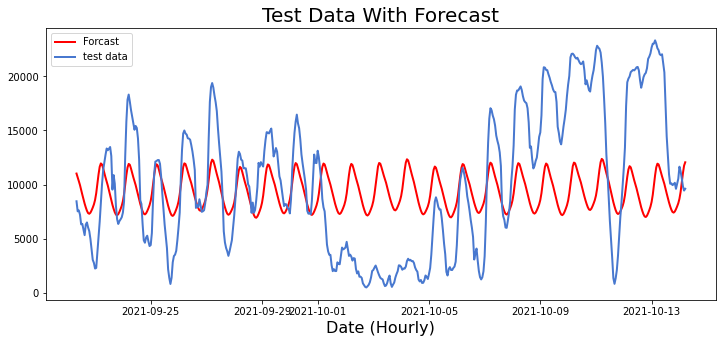

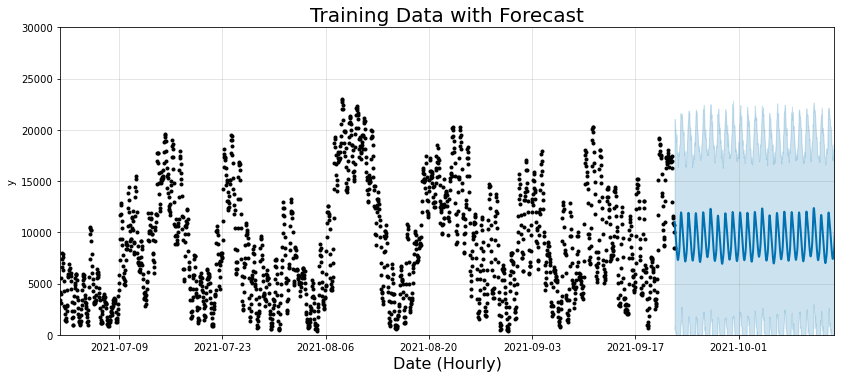

In [456]:
# Fit model to training data and forecast
prophet_model(train, test, interval_width= 0.95)

This is the first Iteration of our Prophet model. We can see above that the Model Captures the seasonality of the daily flucutaions of the wind power but the forcasting looks to be rather linear. We can also see the 95% confedence interval in blue this interval is showing us that 95% of our projected power output will be inside that interval.

Model Evaluation: {'MAE': 5075, 'MSE': 37603258, 'RMSE': 6132}

Null Model Assume the Mean: {'MAE': 5547, 'MSE': 42310454, 'RMSE': 6504}

We can see that the Prophet model performed better than the SARIMA models. It looks like Porphet modeled the daily seasonality better than the SARIA model and was able to model the overall mean of the data better.

### Model #4 Facebook Profit: Seasonal Parameters
Now We will Adjust some of the parameters of the the model, to see how the model adjusts to daily seasonality and yearly seasonality.

In [449]:
# Run the model with Yearly seasonality and Daily seasonality
model = proph(
    interval_width = 0.95,
    yearly_seasonality=True,
    daily_seasonality=True,
    )

model.fit(train)
forecast = model.predict(test)

Initial log joint probability = -340.983
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       10510.7   1.11022e-05       35.4384   4.852e-07       0.001      113  LS failed, Hessian reset 
      69       10510.7   7.55326e-06       30.4138   2.076e-07       0.001      167  LS failed, Hessian reset 
      70       10510.7   2.45647e-06       19.0504           1           1      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Model Evaluation: {'MAE': 4864.536, 'MSE': 34840042.967, 'RMSE': 5902.545}
Null Model Assume the Mean: {'MAE': 5547.285, 'MSE': 42310454.503, 'RMSE': 6504.649}


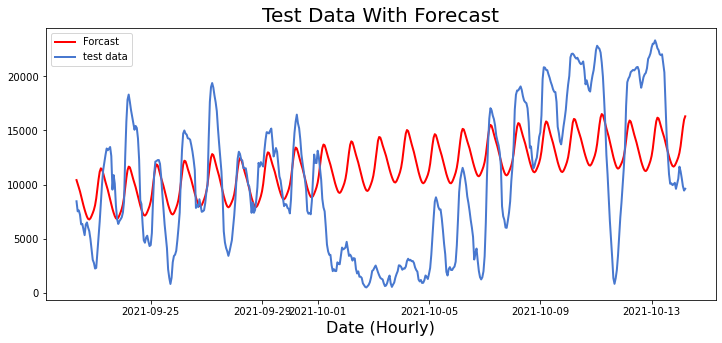

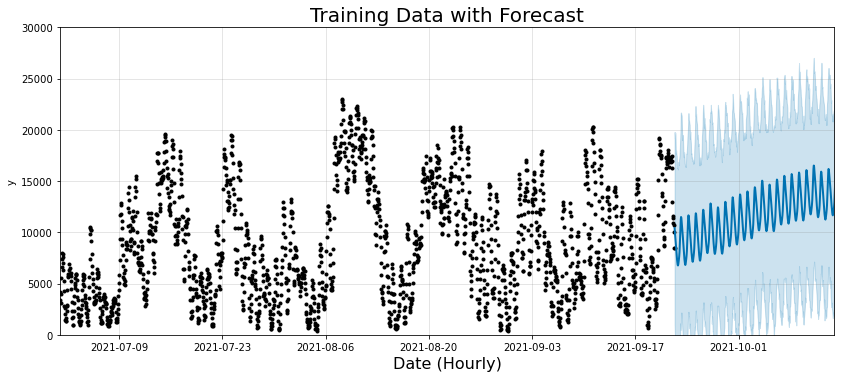

In [451]:
plt.figure(figsize=(12,5))
plt.plot(forecast.ds, forecast.yhat, color='red', label='Forcast')
plt.plot(test.ds,test.y, label='test data')
plt.title('Test Data With Forecast', fontsize=20)
plt.xlabel("Date (Hourly)", fontsize=16)
plt.legend();

# plot forcast data with CI, and training data
fig = model.plot(forecast, uncertainty=True, figsize=(12, 5))
plt.ylim(bottom=0, top=30000)
plt.title("Training Data with Forecast", fontsize=20)
plt.xlabel("Date (Hourly)", fontsize=16);
plt.xlim([dt.date(2021,7,1), dt.date(2021,10,14)])

#evaluate the model
y_true = test[['y']].reset_index(drop=True)
y_pred = forecast[['yhat']].reset_index(drop=True)
print("Model Evaluation:",evaluate_model(y_true, y_pred))
y_true = test[['y']].reset_index(drop=True)
y_pred = np.full_like(y_true, y_true.mean())
print("Null Model Assume the Mean:",evaluate_model(y_true, y_pred))

In our final iteration of using prophet, we see that adding yearly and daily seasonality decreases our RMSE from our original model to 5902 mwh, about a 3% decrease. This is still not a very accurate model to exactly predict exactly what power demand will be but I am reminded that when your model is forcasting, the weather, it can be used to better infer the forcasted value with the 95% confedence interval, i.e. we are 95 percent confedent that our forcast will be with in that range. We can take a look at some of these Confedence intervals below.

In [454]:
# Example of the forcast object containing 
df_forecast = forcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df_forecast.loc[(df_forecast['ds'] >= "2021-10-12") & (df_forecast['ds'] <= "2021-10-14")].head(10)

,ds,yhat,yhat_lower,yhat_upper
28699,2021-10-12 00:00:00,10215.076575,1099.371693,18703.154983
28700,2021-10-12 01:00:00,10729.584918,2153.487090,19926.698639
28701,2021-10-12 02:00:00,11445.069524,2219.376105,20695.342863
28702,2021-10-12 03:00:00,12225.833465,3380.857275,20698.704019
28703,2021-10-12 04:00:00,12845.988550,3854.152565,21946.619934
28704,2021-10-12 05:00:00,13130.736171,3812.646372,22106.814008
28705,2021-10-12 06:00:00,13064.057238,3829.031072,22225.118065
28706,2021-10-12 07:00:00,12777.271163,3150.628576,21255.608699
28707,2021-10-12 08:00:00,12436.197483,3906.989078,21349.697515
28708,2021-10-12 09:00:00,12127.346179,3514.980883,21433.492232


Above is the forcast dataframe from the prophet model. You can see the 95% conv

# Conclusion and Recomendations
---

Returning to our problem statement can we build a model to accurately forecast the wind-power output for the ERCOT grid better than our null model of the mean. The answer is yes using our final prophet model, which included yearly and daily seasonality. Predicting better than the mean of our test data is not a huge feat our RMSE was 5902 MWH which is about 25% - 33% of our 95% confidence interval; however, we did learn that with this data Facebook prophet performed better than our 2 SARIMA models. 

Predicting windpower output is synonymous with predicting the weather.  Time series models predict the overall trend of the data, and they attempt to model in seasonal shocks to the trend of the data. In our case, the shocks to the system are the movements of high and low-pressure systems.

In a future iteration of this model, I want to look into hyper-parameter tuning using cross-validation of the prophet model. I didn't look into tuning the "changepoint_prior_scale", and "seasonality_prior_scale", which determines the flexibility of the trend, and in particular how much the trend changes at changepoints either seasonally, or in one season.  I also want to look into how the predictions are affected by changing the sample rate and seeing if the model forecasts daily or weekly data better than hourly.    